In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting as bkp
import math
import statsmodels.api as sm
#from mpl_toolkits.axes_grid1 import make_axes_locatables

In [2]:
# read in readmissions data provided
hospital_read_df = pd.read_csv('data/cms_hospital_readmissions.csv')

****
## Preliminary Analysis

In [3]:
# deal with missing and inconvenient portions of data 
clean_hospital_read_df = hospital_read_df[hospital_read_df['Number of Discharges'] != 'Not Available']
clean_hospital_read_df.loc[:, 'Number of Discharges'] = clean_hospital_read_df['Number of Discharges'].astype(int)
clean_hospital_read_df = clean_hospital_read_df.sort_values('Number of Discharges')

C:\Users\amaguire\AppData\Local\Continuum\anaconda3\envs\mypy36\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


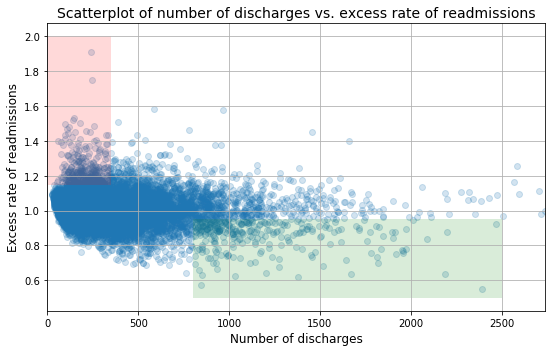

In [4]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function
x = [a for a in clean_hospital_read_df['Number of Discharges'][81:-3]]
y = list(clean_hospital_read_df['Excess Readmission Ratio'][81:-3])

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

****

## Preliminary Report

Read the following results/report. While you are reading it, think about if the conclusions are correct, incorrect, misleading or unfounded. Think about what you would change or what additional analyses you would perform.

**A. Initial observations based on the plot above**
+ Overall, rate of readmissions is trending down with increasing number of discharges
+ With lower number of discharges, there is a greater incidence of excess rate of readmissions (area shaded red)
+ With higher number of discharges, there is a greater incidence of lower rates of readmissions (area shaded green) 

**B. Statistics**
+ In hospitals/facilities with number of discharges < 100, mean excess readmission rate is 1.023 and 63% have excess readmission rate greater than 1 
+ In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is 0.978 and 44% have excess readmission rate greater than 1 

**C. Conclusions**
+ There is a significant correlation between hospital capacity (number of discharges) and readmission rates. 
+ Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions.

**D. Regulatory policy recommendations**
+ Hospitals/facilties with small capacity (< 300) should be required to demonstrate upgraded resource allocation for quality care to continue operation.
+ Directives and incentives should be provided for consolidation of hospitals and facilities to have a smaller number of them with higher capacity and number of discharges.

A. Do you agree with the above analysis and recommendations? Why or why not?

I do not agree with the analysis or recommendations. Here are the problems I see:
With the visualization, the greater incidence of excess readmissions for the low-discharge facilities (LDFs) as compared to high-discharge faciliteis (HDFs) could be simply attributable to how the readmissions are distributed. The density of excess readmission seems to depend on capacity: there are more LDfs than HDFs, so the excess readmission rates are not evenly distributed across the range of total discharges. This means the pattern could be due to chance; if more HDFs were sampled, it is possible to observe more of them that have high excess readmissions. Also, the LDFs have two potential outliers with extremely high excess readmission rates.
The supporting statistics in Section B "cherry-pick" the data into the extreme groups. Only 10% of all facilities are below 100 discharges, and only 4% are above 1000 discharges. Essentially, section B ignores 86% of sample. It's a very misleading way to present the data. 
Section C reports "a significant correlation" but no estimate of a correlation is provided, nor is the result of a statistical test of a correlation estimate. 
Section D issues specific recommendations for "small capacity" hospitals which they define as less than 300 discharges, but it isn't clear if this represents a meaningful cutpoint. Also, the recommendation for consolidation of small-capacity facilities is premature. Even if there is an association between capacity and readmissions, there is no evidence that small capacity is causing readmissions, and no basis for predicting that increasing capacity would reduce readmissions. 

B. Provide support for your arguments and your own recommendations with a statistically sound analysis:


In [5]:
# create a dataframe that is easier to work with, and drop rows with missing readmission ratio

df = clean_hospital_read_df
df.rename(columns={'Number of Discharges': 'discharges', 'Excess Readmission Ratio': 'err'}, inplace=True)
df = df[df.err.notnull()]

### 1 Setup an appropriate hypothesis test.
I want to test the hypothesis that capacity (as measured by total discharges) is related to excess readmissions as defined in the background. There, an "excessive" readmission ratio is said to be greater than 1. 
Null hypothesis - Capacity is not related to excess readmissions
Alternate - Capacity is related to excess readmissions 

In [6]:
# create dichotomous excessive readmission ratio variable 
# errdic  is 0 for errs less than or equal to 1, and 1 for errs above 1
df.loc[df['err'] <=1 , 'errdic'] = 0
df.loc[df['err'] > 1, 'errdic'] = 1

C:\Users\amaguire\AppData\Local\Continuum\anaconda3\envs\mypy36\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [7]:
# Add an intercept column

df['intercept'] = 1

C:\Users\amaguire\AppData\Local\Continuum\anaconda3\envs\mypy36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### 2. Compute and report the observed significance value (or p-value).
I will run a logistic regression model with excess readmission as the outcome, and total discharges as the predictor

In [8]:
# set up a logistic regrsssion model to predict excess readmissions from total discharges
logit = sm.Logit(df['errdic'],df[['discharges','intercept']])

# fit the model
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.691359
         Iterations 4


In [9]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                 errdic   No. Observations:                11497
Model:                          Logit   Df Residuals:                    11495
Method:                           MLE   Df Model:                            1
Date:                Mon, 04 Mar 2019   Pseudo R-squ.:                0.001789
Time:                        10:33:34   Log-Likelihood:                -7948.6
converged:                       True   LL-Null:                       -7962.8
                                        LLR p-value:                 9.421e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
discharges    -0.0003   6.18e-05     -5.279      0.000      -0.000      -0.000
intercept      0.1855      0.029      6.338      0.000       0.128       0.243


In [10]:
print(result.conf_int())

                   0         1
discharges -0.000448 -0.000205
intercept   0.128155  0.242898


In [11]:
print(np.exp(result.params))

discharges    0.999674
intercept     1.203852
dtype: float64


In [12]:
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print(np.exp(conf))

                2.5%     97.5%        OR
discharges  0.999552  0.999795  0.999674
intercept   1.136730  1.274938  1.203852


The odds ratio for discharges is estimated at 0.9999, with a p-value less than 0.0001 and a 95% confidence interval of .999 to 1.00. This means that for each unit increase in discharges, the excess readmissions changes by a factor of ~1 i.e. there is no change.

### 3 Report statistical significance for $\alpha$ = .01.
I will re-print the model summary with the alpha level set at .01. 

In [13]:
print(result.summary(alpha=.01))
print(result.conf_int(alpha=.01))
print(np.exp(result.params))
params = result.params
conf = result.conf_int(alpha=.01)
conf['OR'] = params
conf.columns = ['0.5%', '99.5%', 'OR']
print(np.exp(conf))

                           Logit Regression Results                           
Dep. Variable:                 errdic   No. Observations:                11497
Model:                          Logit   Df Residuals:                    11495
Method:                           MLE   Df Model:                            1
Date:                Mon, 04 Mar 2019   Pseudo R-squ.:                0.001789
Time:                        10:33:34   Log-Likelihood:                -7948.6
converged:                       True   LL-Null:                       -7962.8
                                        LLR p-value:                 9.421e-08
                 coef    std err          z      P>|z|      [0.005      0.995]
------------------------------------------------------------------------------
discharges    -0.0003   6.18e-05     -5.279      0.000      -0.000      -0.000
intercept      0.1855      0.029      6.338      0.000       0.110       0.261
                   0         1
discharges -0.000486 

The p value for alpha = .01 is less than 0.0001. This is the same as the p value when alpha was .05. 

### 4   Discuss statistical significance and practical significance. Do they differ here? How does this change your recommendation to the client?

Statistical significance refers to whether a test statistic estimated from the sample is sufficiently extreme to reject a null hypothesis, because if we assume the null hypothesis is true, the probability of obtaining that estimate by chance is small. Statistical significance can indicate whether there is some association in the data, but it does not indicate how strong that association is. 

In contrast, practical significance refers to measures of effect size that estimate the strength of an association in the data. Most effect size estimates are scaled in a way that communicates the strength of the association in some real-world or practical terms. A "practically significant" result reflects a pattern in the data of a meaningful magnitude, and the effect size provides an idea of "how meaningful" that pattern is.  

In this case statistical significance and practical significance disagree. While there is a statistically significant impact of discharges on excess readmissions, the effect size is negligible i.e. change in discharges does not cause a practical change in excess readmissions. Therefore, I would not recommend that small-capacity hospitals be required to demonstrate upgraded resource allocation, or that incentives be provided for consolidation. Instead, I might try to obtain data on other factors at the hospital level that show a meaningful association with excess readmission rates.

### 5   Look at the scatterplot above. 
 - What are the advantages and disadvantages of using this plot to convey information?

An advantage of the scatterplot is that it displays all the data points in one view, which can be useful in identifying some trends or odd patterns that might not be seen otherwise.  The scatterplot can also help identify any extreme data points that could be problematic at the analysis stage, such as outliers or miscoded/misentered variables. 
Disadvantages are that if the scatterplot is dense (like this one), it can be difficult to perceive a trend even if it exists. Also, a perceived trend from the scatterplot could be misleading, because because there is no indication of model fit or pattern. 

 - Construct another plot that conveys the same information in a more direct manner.

The purpose is to show the relationship between readmissions and discharges. I chose to split the dataset into 20-evenly sized groups in sorted order from least to most discharges, that is, I "cut" the sample at every 5th percentile of discharges. For each group I plotted the mean readmission rate in a bar at the mean discharge. I think this is a more balanced way to achieve the purpose, with sufficient detail but not too much detail to make it difficult to infer a pattern. 

In [14]:
plist = []
for i in range(0, 100, 5):
    plist.append(i)

In [15]:
df2mn = df.groupby(pd.cut(df.discharges, np.percentile(df.discharges, plist), include_lowest=True)).mean()

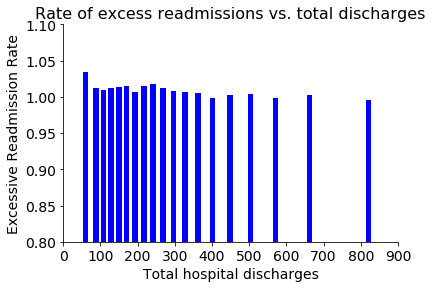

In [16]:
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.ylim(0.8, 1.1)  
plt.xlim(0, 900)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.ylabel("Excessive Readmission Rate", fontsize=14) 
plt.xlabel("Total hospital discharges", fontsize=14)
plt.title("Rate of excess readmissions vs. total discharges", fontsize=16) 
plt.bar(df2mn.discharges, df2mn.err, 15, color='b', label='Discharges')
plt.show()